# Working with GRACE to build a mask and calculate water balance

by Anthony Arendt and Landung Setiawan

Datasets:
- GRACE: https://ssed.gsfc.nasa.gov/grace/products.html
- LIS: https://github.com/NASA-Planetary-Science/HiMAT/tree/master/Projects/LIS

This is a continuation to the LIS Dataset processing workflow. [<<](../LIS/)

This code is designed to access files directly on the NASA ADAPT system

In [1]:
# Import the necessary libraries
%matplotlib inline
import os
import glob
import sys
import datetime
import pickle
from datetime import timedelta

import xarray as xr

import pandas as pd
import numpy as np

import geopandas as gpd

from dask.diagnostics import ProgressBar

import seaborn as sb

import matplotlib
import matplotlib.pyplot as plt
matplotlib.style.use('ggplot')

import regionmask

from shapely.geometry import Polygon

import cartopy.crs as ccrs
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

from himatpy.LIS import utils
from himatpy.tools import animation_tools
from himatpy.GRACE_MASCON.pygrace import (extract_grace, get_mascon_gdf, get_cmwe_trend_analysis, build_mask)

In [2]:
datadir = os.path.abspath('/att/nobackup/lsetiawa/')

## Get GRACE Data

In [3]:
# Read in mascon file
grace_file = os.path.join(datadir, 'LIS', 'GSFC.glb.200301_201607_v02.3b-ICE6G.h5')
try:
    f = extract_grace(grace_file)
except FileNotFoundError as e:
    print(e)

Data extracted: 
---
Group: mascon
---
<HDF5 dataset "area_deg": shape (1, 41168), type "<f8">
<HDF5 dataset "area_km2": shape (1, 41168), type "<f8">
<HDF5 dataset "basin": shape (1, 41168), type "<f8">
<HDF5 dataset "elev_flag": shape (1, 41168), type "<f8">
<HDF5 dataset "lat_center": shape (1, 41168), type "<f8">
<HDF5 dataset "lat_span": shape (1, 41168), type "<f8">
<HDF5 dataset "location": shape (1, 41168), type "<f8">
<HDF5 dataset "lon_center": shape (1, 41168), type "<f8">
<HDF5 dataset "lon_span": shape (1, 41168), type "<f8">
---
Group: size
---
<HDF5 dataset "N_arcs": shape (1, 1), type "<f8">
<HDF5 dataset "N_mascon_times": shape (1, 1), type "<f8">
<HDF5 dataset "N_mascons": shape (1, 1), type "<f8">
---
Group: solution
---
<HDF5 dataset "cmwe": shape (41168, 148), type "<f8">
<HDF5 dataset "uncertainty": shape (41168, 148), type "<f8">
---
Group: time
---
<HDF5 dataset "list_ref_days_solution": shape (1, 4128), type "<f8">
<HDF5 dataset "n_ref_days_solution": shape (1,

In [4]:
mascon = f['mascon']
soln = f['solution']
time = f['time']

In [5]:
# Get mascon gdf
mascon_gdf = get_mascon_gdf(mascon)

# we need to track mascon numbers later, which we get from the index, so make a new "mascon" column
mascon_gdf['mascon'] = mascon_gdf.index

There are 41168 Mascons in this dataset.


In [6]:
# Filter only mascon within HMA geographical areas
HMA = mascon_gdf[(mascon_gdf['location'] == 80.0) & ((mascon_gdf['basin'] > 5000.0) & (mascon_gdf['basin'] < 6100.0))]

## Retrieve NASA Land Information System (LIS) Dataset

In [7]:
lis_file = os.path.join(datadir, 'LISMonthly.nc')
lis_ds = xr.open_dataset(lis_file, chunks={'time': 10})
# getting the max/min lat/lon from the LIS dataset
minLong = lis_ds.coords['longitude'].min().values
maxLong = lis_ds.coords['longitude'].max().values
minLat = lis_ds.coords['latitude'].min().values
maxLat = lis_ds.coords['latitude'].max().values
bbox = [minLong, minLat, maxLong, maxLat]

In [8]:
lis_ds['Qsm_tavg']

<xarray.DataArray 'Qsm_tavg' (time: 192, north_south: 1696, east_west: 1896)>
dask.array<open_dataset-bd08889e4f56ade7e3f7fe8ff88ddd81Qsm_tavg, shape=(192, 1696, 1896), dtype=float64, chunksize=(10, 1696, 1896)>
Coordinates:
    longitude  (north_south, east_west) float64 66.03 66.04 66.05 66.06 ...
    latitude   (north_south, east_west) float64 22.02 22.02 22.02 22.02 ...
  * time       (time) datetime64[ns] 2001-01-01 2001-02-01 2001-03-01 ...
Dimensions without coordinates: north_south, east_west
Attributes:
    units:          mm we
    standard_name:  snowmelt
    long_name:      Cumulative monthly snowmelt in units of mm we
    vmin:           0.0
    vmax:           0.0

## Build Mask

Using the [regionmask](http://regionmask.readthedocs.io/en/stable/index.html) library

In [9]:
m, gpd_intersect = build_mask(bbox, HMA, dacoords=lis_ds.coords, serialize=True, datadir=datadir)

Exporting /att/nobackup/lsetiawa/gracemsk.nc


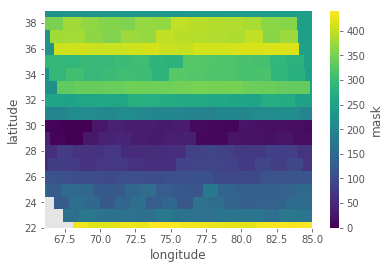

In [10]:
m.plot(x='longitude', y='latitude')

## Apply Mask

"stacked_north_south_east_west" comes from regionmask example. It appears to be a method for multidimensional masking. This is still a bit foggy.

In [11]:
ds_masked = lis_ds.groupby(m).mean('stacked_north_south_east_west')

In [13]:
ds_masked.coords['mascon'] = ('mask', gpd_intersect['mascon'].values[ds_masked.coords['mask'].values.astype('int')])

#### Now the mask is part of the coordinates

In [12]:
ds_masked

<xarray.Dataset>
Dimensions:     (mask: 304, time: 192)
Coordinates:
  * time        (time) datetime64[ns] 2001-01-01 2001-02-01 2001-03-01 ...
  * mask        (mask) float64 0.0 1.0 3.0 4.0 5.0 6.0 7.0 9.0 10.0 12.0 ...
Data variables:
    Qsm_tavg    (mask, time) float64 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 ...
    Rainf_tavg  (mask, time) float64 0.00575 1.573 2.159 40.24 0.5293 9.418 ...
    Qs_tavg     (mask, time) float64 0.0001055 0.02523 0.03486 0.5914 ...
    Snowf_tavg  (mask, time) float64 6.288e-05 1.609e-05 3.359e-17 0.0 0.0 ...
    Qsb_tavg    (mask, time) float64 0.6377 0.5884 0.6433 0.6147 0.6317 ...
    Evap_tavg   (mask, time) float64 6.498 4.668 5.312 22.78 9.491 7.929 ...
    TWS_tavg    (mask, time) float64 1.56e+05 1.454e+05 1.609e+05 1.559e+05 ...

### Convert everything to a Pandas dataframe for easier evaluation

In [14]:
with ProgressBar():
    mdf = ds_masked.to_dataframe()

[########################################] | 100% Completed | 17.0s
[########################################] | 100% Completed | 15.8s
[########################################] | 100% Completed | 16.8s
[########################################] | 100% Completed | 17.0s
[########################################] | 100% Completed | 17.0s
[########################################] | 100% Completed | 17.2s
[########################################] | 100% Completed | 17.2s


In [15]:
mdf.head()

Qsm_tavg  Rainf_tavg   Qs_tavg    Snowf_tavg  Qsb_tavg  \
mask time                                                                 
0.0  2001-01-01       0.0    0.005750  0.000105  6.288375e-05  0.637697   
     2001-02-01       0.0    1.572855  0.025225  1.608942e-05  0.588437   
     2001-03-01       0.0    2.158684  0.034859  3.358837e-17  0.643275   
     2001-04-01       0.0   40.241033  0.591367  0.000000e+00  0.614738   
     2001-05-01       0.0    0.529290  0.007452  0.000000e+00  0.631675   

                 Evap_tavg       TWS_tavg  mascon  
mask time                                          
0.0  2001-01-01   6.497751  155973.542914    8119  
     2001-02-01   4.668368  145432.582280    8119  
     2001-03-01   5.312384  160911.182782    8119  
     2001-04-01  22.778068  155926.765992    8119  
     2001-05-01   9.491286  161194.044970    8119

### Calculate the waterbalance. GRACE represents cumulative mass so we calculate cumulative sum for GRACE comparison

In [19]:
mdf['waterbal'] = mdf['Rainf_tavg'] + mdf['Snowf_tavg'] - (mdf['Qsb_tavg'] + mdf['Qsm_tavg'] + mdf['Evap_tavg'])
mdf['waterbal_cumulative'] = mdf.groupby(['mask'])['waterbal'].apply(lambda x: x.cumsum())

In [20]:
mdf.head()

Qsm_tavg  Rainf_tavg   Qs_tavg    Snowf_tavg  Qsb_tavg  \
mask time                                                                 
0.0  2001-01-01       0.0    0.005750  0.000105  6.288375e-05  0.637697   
     2001-02-01       0.0    1.572855  0.025225  1.608942e-05  0.588437   
     2001-03-01       0.0    2.158684  0.034859  3.358837e-17  0.643275   
     2001-04-01       0.0   40.241033  0.591367  0.000000e+00  0.614738   
     2001-05-01       0.0    0.529290  0.007452  0.000000e+00  0.631675   

                 Evap_tavg       TWS_tavg  mascon   waterbal  \
mask time                                                      
0.0  2001-01-01   6.497751  155973.542914    8119  -7.129635   
     2001-02-01   4.668368  145432.582280    8119  -3.683934   
     2001-03-01   5.312384  160911.182782    8119  -3.796974   
     2001-04-01  22.778068  155926.765992    8119  16.848226   
     2001-05-01   9.491286  161194.044970    8119  -9.593671   

                 waterbal_cumulative  
mask time                             
0.0  2001-01-01            -7.129635  
     2001-02-01           -10.813569  
     2001-03-01           -14.610543  
     2001-04-01             2.237683  
     2001-05-01            -7.355988

In [21]:
mdf.to_pickle(os.path.join(datadir, 'LIS_by_mascon.pkl'))

### This workflow continues on another notebook [>>](./path_here)